In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [3]:
# Read the training data from multiple CSV files
train_1 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv')
train_2 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv')
train_3 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv')
train_4 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv')


In [4]:
# Load the main data from another CSV file
main = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')

# Select relevant columns from each DataFrame
train_1 = train_1[['text', 'label']]
train_2 = train_2[['text', 'label']]
train_3 = train_3[['text', 'label']]
train_4 = train_4[['text', 'label']]

main = main[['text', 'generated']]
main = main.set_axis(['text', 'label'], axis=1)

In [5]:
# Concatenate the data from different sources
df = pd.concat([train_1, train_2, train_3, train_4, main])

# Check for missing values in the concatenated dataset
missing_values_train = df.isnull().sum()
print("Missing values in the concatenated dataset:\n", missing_values_train)

# Split the data into features (X) and target variable (y)
y = df['label']
X = df['text']

Missing values in the concatenated dataset:
 text     0
label    0
dtype: int64


In [6]:
# Split the data into training and validation sets (adjust the test_size as needed)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Text data preprocessing using Tokenizer and pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
text_sequences_train = tokenizer.texts_to_sequences(X_train)
text_sequences_valid = tokenizer.texts_to_sequences(X_valid)

X_train = pad_sequences(text_sequences_train, maxlen=2000)
X_valid = pad_sequences(text_sequences_valid, maxlen=2000)

In [7]:
# DNN model architecture (customize as needed)
input_layer = Input(shape=(X_train.shape[1],))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 501, output_dim=32)(input_layer)

conv1d_1 = Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01))(embedding_layer)
conv1d_1 = BatchNormalization()(conv1d_1)
conv1d_1 = Dropout(0.2)(conv1d_1)
maxpooling_1 = GlobalMaxPooling1D()(conv1d_1)

flatten_layer = Flatten()(embedding_layer)
hidden_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(flatten_layer)
hidden_layer = BatchNormalization()(hidden_layer)
hidden_layer = Dropout(0.2)(hidden_layer)

In [8]:

# Concatenate the results from Conv1D and Dense layers
concatenated = Concatenate()([maxpooling_1, hidden_layer])

output_layer = Dense(1, activation='sigmoid')(concatenated)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 2000, 32)             3069504   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 1996, 128)            20608     ['embedding[0][0]']           
                                                                                                  
 flatten (Flatten)           (None, 64000)                0         ['embedding[0][0]']           
                                                                                              

Epoch 1/5
252/252 [==============================] - 1290s 5s/step - loss: 0.4578 - accuracy: 0.9762 - val_loss: 0.4861 - val_accuracy: 0.9961
Epoch 2/5
252/252 [==============================] - 1281s 5s/step - loss: 0.0893 - accuracy: 0.9970 - val_loss: 0.1124 - val_accuracy: 0.9950
Epoch 3/5
252/252 [==============================] - 1286s 5s/step - loss: 0.0445 - accuracy: 0.9980 - val_loss: 0.0539 - val_accuracy: 0.9924
Epoch 4/5
252/252 [==============================] - 1282s 5s/step - loss: 0.0303 - accuracy: 0.9986 - val_loss: 0.0559 - val_accuracy: 0.9910
Epoch 5/5
252/252 [==============================] - 1282s 5s/step - loss: 0.0238 - accuracy: 0.9989 - val_loss: 0.0524 - val_accuracy: 0.9884


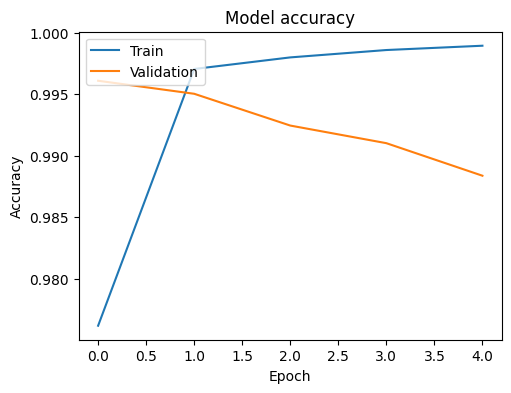

In [9]:
# Training the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5, batch_size=512)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

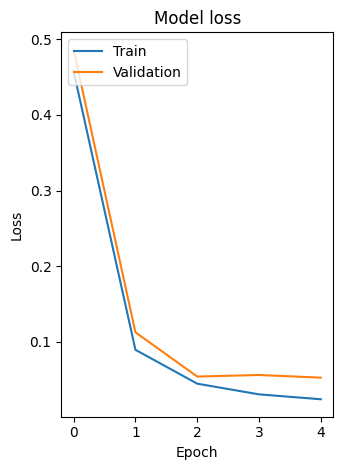

In [10]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
# Evaluate the model on the validation set
y_pred_valid = (model.predict(X_valid) > 0.5).astype("int32")

# Print evaluation metrics
print("Validation Accuracy:", accuracy_score(y_valid, y_pred_valid))
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred_valid))
print("Classification Report:\n", classification_report(y_valid, y_pred_valid))

# Text data preprocessing for the test set
test_df = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
text_sequences_test = tokenizer.texts_to_sequences(test_df['text'])
X_test = pad_sequences(text_sequences_test, maxlen=2000)

1006/1006 [==============================] - 43s 43ms/step
Validation Accuracy: 0.9883731774800261
Confusion Matrix:
 [[23294     4]
 [  370  8499]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     23298
           1       1.00      0.96      0.98      8869

    accuracy                           0.99     32167
   macro avg       0.99      0.98      0.99     32167
weighted avg       0.99      0.99      0.99     32167



In [12]:
# Make predictions on the test set
y_pred_test = (model.predict(X_test) > 0.5).astype("int32")

# Prepare the submission DataFrame
sub_df = test_df[["id"]].copy()
sub_df["generated"] = y_pred_test.squeeze()

# Save the submission to a CSV file
sub_df.to_csv('submission.csv', index=False)

# Display the first 2 rows of the submission DataFrame
sub_df.head()

1/1 [==============================] - 0s 28ms/step


,id,generated
0,0000aaaa,1
1,1111bbbb,1
2,2222cccc,1
